In [194]:
import torch
from pathlib import Path
import torch
import torchvision
from torch import nn
from torchvision import transforms
from dataclasses import dataclass
from torch.utils.tensorboard import SummaryWriter  

In [195]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [196]:
@dataclass
class ModelArgs:
    latent_vector_size = 100
    device = 'cpu'
    batch_size = 64
    lr = 5e-5
    num_classes = 10
    img_size = 64
    no_of_lables = 10
    no_of_channels = 1
    c = 1e-2
    nCritic = 5


In [197]:
ModelArgs.device = device

In [198]:
#Transforms for images
transforms = torchvision.transforms.Compose([
    transforms.Resize(size=(ModelArgs.img_size,ModelArgs.img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

In [199]:
#Loading MNIST Dataset
import torchvision
from torch.utils.data import DataLoader
import os

data_path = Path('/content/data/')

# train_dir = data_path / "train"
# test_dir = data_path / "test"

# Load the training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=ModelArgs.batch_size, shuffle=True)

# Load the test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=ModelArgs.batch_size, shuffle=False)

In [200]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [201]:
class Generator(nn.Module):
    def __init__(
        self,
        latent_vector_size = 100,
        no_of_channels = 1,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
        z_out_dimensions: int = 200,
        y_out_dimensions: int = 1000,
        labels_size: int = 10,
        combined_hidden_layer_dimensions: int = 1200,
        img_size: int = 1

    ):

        super().__init__()

        # self.linear_z_out = nn.Linear(in_features=latent_vector_size, out_features=z_out_dimensions, device=ModelArgs.device)
        # self.linear_y_out = nn.Linear(in_features=ModelArgs.no_of_lables, out_features=y_out_dimensions, device=ModelArgs.device)
        # self.combined = z_out_dimensions + y_out_dimensions
        # self.combined_layer = nn.Linear(in_features=self.combined, out_features=combined_hidden_layer_dimensions, device=ModelArgs.device)
        self.dense = nn.Linear(in_features=latent_vector_size, out_features=img_size * img_size, device=device)
        self.combined_hidden_layer_dimensions = latent_vector_size + ModelArgs.no_of_lables
        self.embedding = nn.Embedding(num_embeddings=ModelArgs.num_classes, embedding_dim=latent_vector_size, device=device)
        # self.wi = weight_initialization()
        self.img_size = img_size
        self.main = nn.Sequential(


            # nn.Linear(in_features=latent_vector_size, out_features=z_out_dimensions, device=ModelArgs.device),
            # nn.Linear(in_features=labels_size, out_features=y_out_dimensions, device=ModelArgs.device),
            nn.ConvTranspose2d(ModelArgs.latent_vector_size + ModelArgs.latent_vector_size, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 16),
            nn.ReLU(),

            #shape = (...,1024, 4, 4)
            nn.ConvTranspose2d(number_of_feature_maps * 16, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.ReLU(),

            #shape = (..., 512, 8, 8)
            nn.ConvTranspose2d(number_of_feature_maps * 8, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(number_of_feature_maps * 4),

             #shape = (..., 256, 16, 16)
            nn.ConvTranspose2d(number_of_feature_maps * 4, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(number_of_feature_maps * 2),

             #shape = (..., 128, 32, 32)
            nn.ConvTranspose2d(number_of_feature_maps * 2, no_of_channels , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.Tanh()
            #shape = (..., 3, 64, 64)
        )

    def forward(self, x, y):
        labels = self.embedding(y)
        # print(x.shape)
        # print(y.shape)
        labels = labels.unsqueeze(2).unsqueeze(3).view(x.shape[0], ModelArgs.latent_vector_size, 1,1)

        combined = torch.cat([x, labels], dim=1)
        # print(combined.shape)
        out = self.main(combined)
        return out

In [166]:
#Intializing the Generator instance
generator = Generator().to(ModelArgs.device)

#Applying the weights transformation
generator.apply(weights_init)

#Printing the structure
print(generator)

Generator(
  (dense): Linear(in_features=100, out_features=1, bias=True)
  (embedding): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2

In [51]:
torch.randint(0, 10, (128, 1), dtype=torch.long, device=ModelArgs.device).shape

torch.Size([128, 1])

In [76]:
from torchinfo import summary

random_data = torch.randn(ModelArgs.batch_size, ModelArgs.latent_vector_size, 1, 1, device=ModelArgs.device)
# labels =
labels = torch.randint(0, 10, (64,), dtype=torch.long, device=ModelArgs.device)
random_data = random_data.to(ModelArgs.device)
summary(model=generator,
        
        # input_size=(128, 100, 10, 1, 1),
        input_data=(random_data, labels),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

torch.Size([64, 100, 1, 1])
torch.Size([64])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [64, 100, 1, 1]      [64, 1, 64, 64]      101                  True
├─Embedding (embedding)                  [64]                 [64, 100]            1,000                True
├─Sequential (main)                      [64, 200, 1, 1]      [64, 1, 64, 64]      --                   True
│    └─ConvTranspose2d (0)               [64, 200, 1, 1]      [64, 1024, 4, 4]     3,276,800            True
│    └─BatchNorm2d (1)                   [64, 1024, 4, 4]     [64, 1024, 4, 4]     2,048                True
│    └─ReLU (2)                          [64, 1024, 4, 4]     [64, 1024, 4, 4]     --                   --
│    └─ConvTranspose2d (3)               [64, 1024, 4, 4]     [64, 512, 8, 8]      8,388,608            True
│    └─BatchNorm2d (4)                   [64, 512, 8, 8]      [64, 512, 8, 8]      1,024                True
│    └─ReLU (5) 

In [13]:
random_data.shape, labels.shape

(torch.Size([128, 100]), torch.Size([128]))

In [141]:

for images, labels in trainloader:

    print(images.shape)
    print(labels.shape)
    break



torch.Size([64, 1, 64, 64])
torch.Size([64])


In [202]:
class Critic(nn.Module):
    def __init__(
        self,
        no_of_channels = 1,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
        lr_slope=0.2,
        num_classes: int = ModelArgs.num_classes,
        z_out_dimensions: int = 200,
        y_out_dimensions: int = 1000,
        labels_size: int = 10,
        combined_hidden_layer_dimensions: int = 1200,
        latent_vector_size: int = ModelArgs.latent_vector_size,
        img_size: int = ModelArgs.img_size
    ):

        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=ModelArgs.num_classes, embedding_dim=ModelArgs.img_size * ModelArgs.img_size, device=ModelArgs.device)


        self.main = nn.Sequential(
            nn.Conv2d(no_of_channels + 1, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 2),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (...,1024, 32, 32)
            nn.Conv2d(number_of_feature_maps * 2, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 4),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 512, 16, 16)
            nn.Conv2d(number_of_feature_maps * 4, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 256, 8, 8)
            nn.Conv2d(number_of_feature_maps * 8, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 16),
            nn.LeakyReLU(negative_slope=lr_slope),
            #  shape = (..., 128, 4, 4)

            nn.Conv2d(number_of_feature_maps * 16, 1 , kernel_size=kernel_size, stride=4, padding=padding, bias=False),
            #shape = (...,1,1)
            nn.Flatten(),
            # nn.Sigmoid(),
         )

    def forward(self, x, y):
        
        y = self.embedding(y)
        B,E = y.shape

        combined = torch.concat([x, y.unsqueeze(2).unsqueeze(3).view(x.shape[0], ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)], dim=1)

        x = self.main(combined)

        return x

In [168]:
# x.view(B, C, IMG_SIZE*IMG_SIZE)

In [169]:
# ModelArgs.device

In [170]:
#Intializing the Discriminator instance
critic = Critic().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
critic = critic.apply(weights_init)
#Printing the structure
print(critic)

Critic(
  (embedding): Embedding(10, 4096)
  (main): Sequential(
    (0): Conv2d(2, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(1024, 1, kernel_size=(4, 4), stride=(4, 4), 

In [172]:
from torchinfo import summary

images = torch.randn(64, 1, 64, 64)
labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=critic,
        # input_size=(100, 1, 64, 64, 10),
        input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Critic (Critic)                          [64, 1, 64, 64]      [64, 1]              1,453,801            True
├─Embedding (embedding)                  [64]                 [64, 4096]           40,960               True
├─Sequential (main)                      [64, 2, 64, 64]      [64, 1]              --                   True
│    └─Conv2d (0)                        [64, 2, 64, 64]      [64, 128, 32, 32]    4,096                True
│    └─BatchNorm2d (1)                   [64, 128, 32, 32]    [64, 128, 32, 32]    256                  True
│    └─LeakyReLU (2)                     [64, 128, 32, 32]    [64, 128, 32, 32]    --                   --
│    └─Conv2d (3)                        [64, 128, 32, 32]    [64, 256, 16, 16]    524,288              True
│    └─BatchNorm2d (4)                   [64, 256, 16, 16]    [64, 256, 16, 16]    512                  True
│    └─LeakyReLU

In [20]:
images.shape, labels.shape

(torch.Size([128, 1, 64, 64]), torch.Size([128]))

In [21]:
# labels = labels.float()
labels = one_hot_encode(labels)
labels = labels.to(ModelArgs.device)

In [22]:
labels

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [220]:
# epochs = 5 #30
# # beta_1 = 0.5
# # lr_optimizer = 0.0002
# loss_fn = nn.BCELoss()  #BCELoss function

generator = Generator().to(ModelArgs.device).apply(weights_init)
critic = Critic().to(ModelArgs.device).apply(weights_init)

# optimizerD = torch.optim.SGD(params=discriminator.parameters(), momentum=ModelArgs.momentum_initial, lr=ModelArgs.initial_lr) #For discriminator
# optimizerG = torch.optim.SGD(params=generator.parameters(), momentum=ModelArgs.momentum_initial, lr=ModelArgs.initial_lr) #For generator


epochs = 200 #30


optimizerC = torch.optim.RMSprop(params=critic.parameters(), lr=ModelArgs.lr) #For discriminator
optimizerG = torch.optim.RMSprop(params=generator.parameters(), lr=ModelArgs.lr) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []

# # Fixed noise for generating the images
# fixed_noise = torch.randn((ModelArgs.batch_size, ModelArgs.latent_vector_size, 1, 1), dtype=torch.float32, device=ModelArgs.device)

In [221]:
import shutil
save_images = Path('output_images/MNIST')


In [115]:
for images, labels in trainloader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([128, 1, 64, 64])
torch.Size([128])


In [162]:
one_hot_encode(torch.randint(low=0, high=ModelArgs.num_classes, size=(current_batch_size,), device=ModelArgs.device))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [222]:
#Training loop

generator.train()
critic.train()
iters = 0

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

for epoch in range(epochs):

    current_batch_size = 0
    
    for _ in range(ModelArgs.nCritic):
    
    
        count = 0
        for X, y in trainloader:
            
            if(count>=ModelArgs.batch_size):
                break
            # global current_batch_size
            
            X = X.to(ModelArgs.device)
            y = y.to(ModelArgs.device)
            
            count += 1
            #Train the discriminator (with real data)

            ############################
            # (1) Update D network: maximize: log(1 - D(G(z)))
            ###########################
            # print("noise : ", noise.shape)
            # print("Labels: ", y.shape)
            # print(X.shape)
            # print(y.shape)
            current_batch_size = X.shape[0]  #Getting the current batch size

            critic_real = critic(X,y).view(-1)
            
            noise = torch.randn((current_batch_size, ModelArgs.latent_vector_size, 1, 1), device=ModelArgs.device)
            
            # print('generated noise; ', noise.shape)
            noise_generated_by_generator = generator(noise, y)
            
            critic_fake = critic(noise_generated_by_generator, y).view(-1)
            loss_tot = -(critic_real.mean() - critic_fake.mean())
            
            # 3. Optimizer zero grad
            optimizerC.zero_grad()

            # 4. Loss backward
            loss_tot.backward(retain_graph=True)
                
            optimizerC.step()
            loss_d.append(loss_tot.item())

            
            for p in critic.parameters():
                p.clamp(-(ModelArgs.c), ModelArgs.c)

    ############################
    # (2) Update G network: minimize log(D(G(z)))
    ###########################
    for X, y in trainloader:
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        
        # global current_batch_size
        
        current_batch_size = X.shape[0]
        
        #1. Forward pass
        noise = torch.randn((current_batch_size, ModelArgs.latent_vector_size, 1, 1), device=ModelArgs.device)
        noise_generated_by_generator = generator(noise, y)
        critic_gen = critic(noise_generated_by_generator, y).view(-1)
        
        loss = -(critic_gen.mean())
        
        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        loss.backward(retain_graph=True)
            
        optimizerG.step()
        
        loss_g.append(loss.item())

    if epoch % 5 == 0:
        print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss.item(), "Discriminator loss: ", loss_tot.item())

    #save the output
    with torch.no_grad():
        if epoch % 5 == 0:
            
            # global current_batch_size
            fixed_noise = torch.randn((current_batch_size, ModelArgs.latent_vector_size, 1, 1), dtype=torch.float32, device=ModelArgs.device)
            print('saving the output')
            torchvision.utils.save_image(X,'{}/real_images_epoch_{}.png'.format(save_images, epoch),normalize=True)
            # global fixed_noise
            fake = generator(fixed_noise, y)
            torchvision.utils.save_image(fake,'{}/fake_images_epoch_{}.png'.format(save_images, epoch),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Mnist Fake Images", img_grid_fake, global_step=epoch
                    )
            writer_real.add_image(
                        "Mnist Real Images", img_grid_real, global_step=epoch
                    )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1


Iterations:  0 Epoch:  0 Generator loss:  -335.45880126953125 Discriminator loss:  -665.2409057617188
saving the output
Iterations:  5 Epoch:  5 Generator loss:  -1090.071044921875 Discriminator loss:  -2154.619873046875
saving the output
Iterations:  10 Epoch:  10 Generator loss:  -1993.0421142578125 Discriminator loss:  -3855.099609375
saving the output
Iterations:  15 Epoch:  15 Generator loss:  -3043.730712890625 Discriminator loss:  -6025.9111328125
saving the output
Iterations:  20 Epoch:  20 Generator loss:  -4238.4111328125 Discriminator loss:  -8355.498046875
saving the output
Iterations:  25 Epoch:  25 Generator loss:  -5578.63818359375 Discriminator loss:  -11042.736328125
saving the output
Iterations:  30 Epoch:  30 Generator loss:  -7077.38623046875 Discriminator loss:  -13982.146484375
saving the output
Iterations:  35 Epoch:  35 Generator loss:  -8716.73828125 Discriminator loss:  -17252.47265625
saving the output


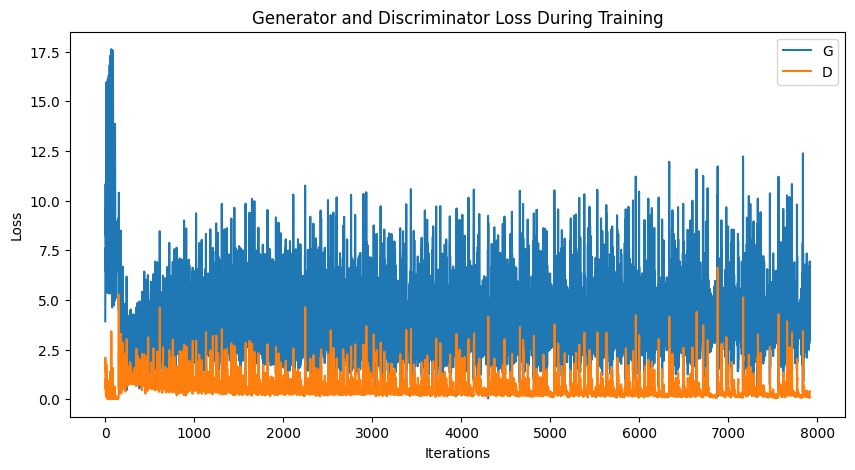

In [ ]:
#For CelebA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



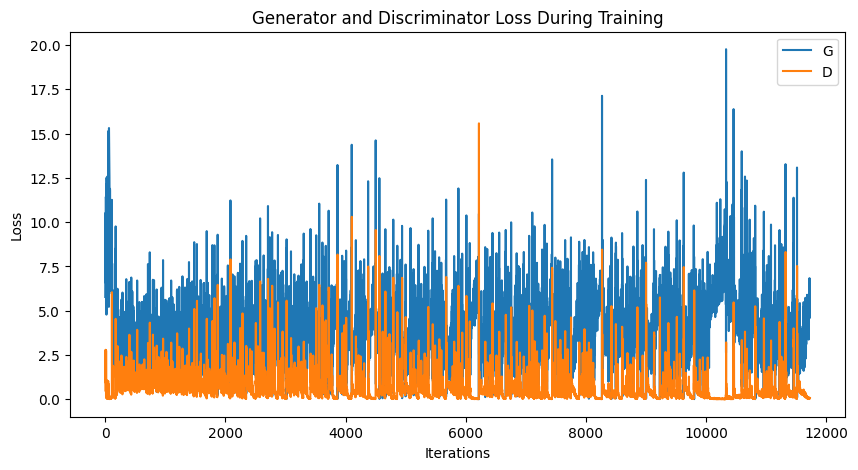

In [ ]:
#For CIFAR10
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

